Device: cpu
Resize: (96, 192) | Batch: 1 | Epochs: 2
Using 12 classes (dropped): Other
Classes: ['Traffic Sign', 'Building', 'Fence', 'Pedestrian', 'Pole', 'Road Line', 'Road', 'Sidewalk', 'Vegetation', 'Car', 'Wall', 'Unlabeled']
Train videos: 19 pairs: 7387
Val videos: 4 pairs: 1515
Test videos: 5 pairs: 1865
Batches -> train: 7387 val: 1515 test: 1865

START TRAINING

Epoch 1/2 |   0.0% | batch 1/7387 | loss 2.6249
Epoch 1/2 |   5.0% | batch 369/7387 | loss 0.4427
Epoch 1/2 |  10.0% | batch 738/7387 | loss 0.3995
Epoch 1/2 |  15.0% | batch 1107/7387 | loss 0.2910
Epoch 1/2 |  20.0% | batch 1476/7387 | loss 0.2975
Epoch 1/2 |  25.0% | batch 1845/7387 | loss 0.2671
Epoch 1/2 |  30.0% | batch 2214/7387 | loss 0.1502
Epoch 1/2 |  35.0% | batch 2583/7387 | loss 0.1542
Epoch 1/2 |  40.0% | batch 2952/7387 | loss 0.2761
Epoch 1/2 |  45.0% | batch 3321/7387 | loss 0.1054
Epoch 1/2 |  50.0% | batch 3690/7387 | loss 0.2276
Epoch 1/2 |  54.9% | batch 4059/7387 | loss 0.2162
Epoch 1/2 |  59.9% 

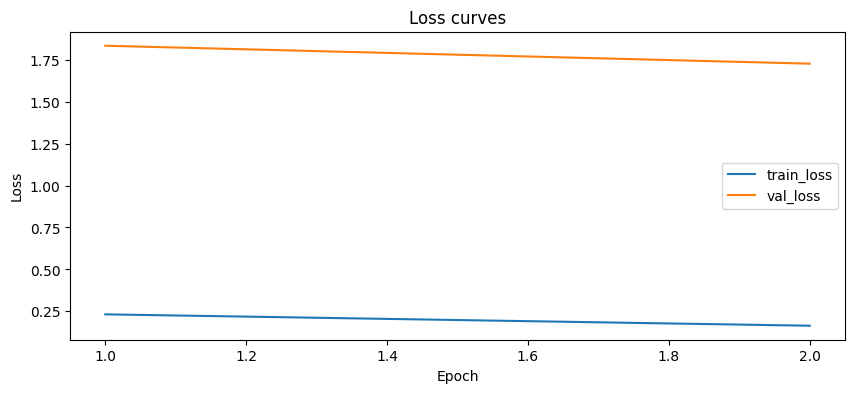

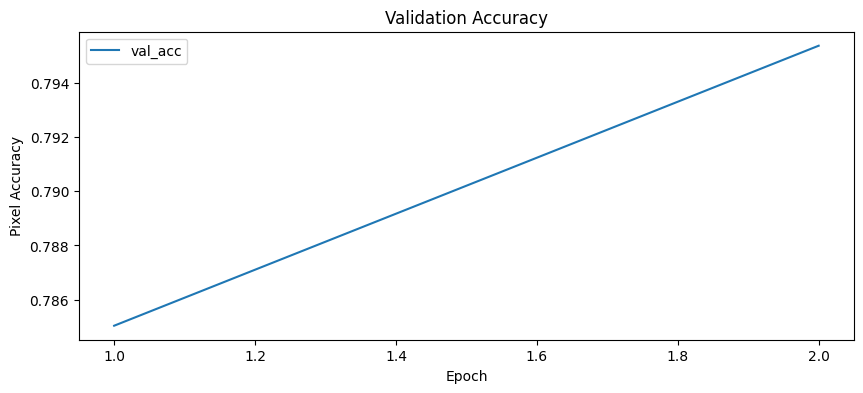

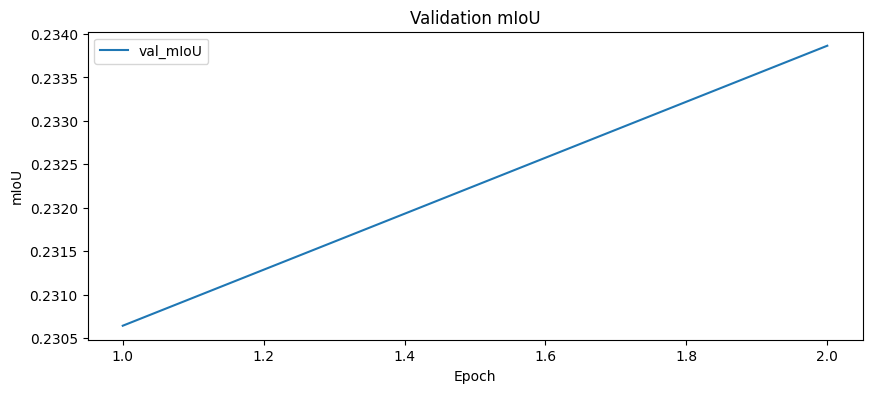

TEST RESULTS
  test_loss: 0.26164002581112505
  pixel_acc: 0.9070691038758203
  mIoU: 0.48997115226552684

IoU per class:
  00 Traffic Sign         IoU=0.0000
  01 Building             IoU=0.8015
  02 Fence                IoU=0.1646
  03 Pedestrian           IoU=0.2340
  04 Pole                 IoU=0.0383
  05 Road Line            IoU=0.2521
  06 Road                 IoU=0.9092
  07 Sidewalk             IoU=0.6505
  08 Vegetation           IoU=0.5933
  09 Car                  IoU=0.7837
  10 Wall                 IoU=0.5275
  11 Unlabeled            IoU=0.9249


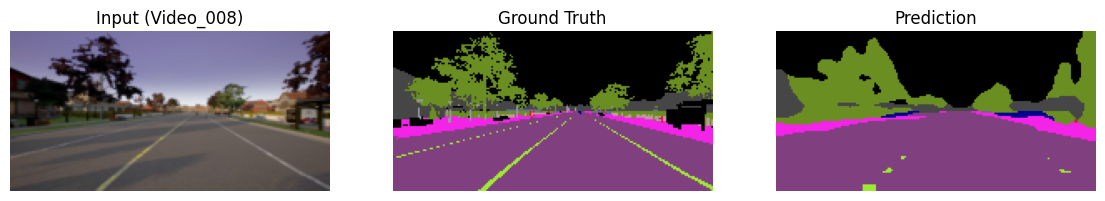

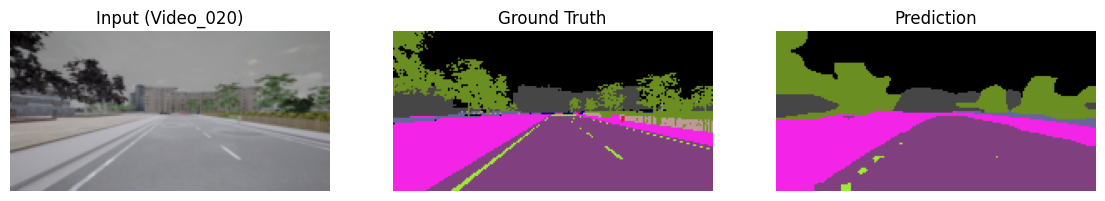

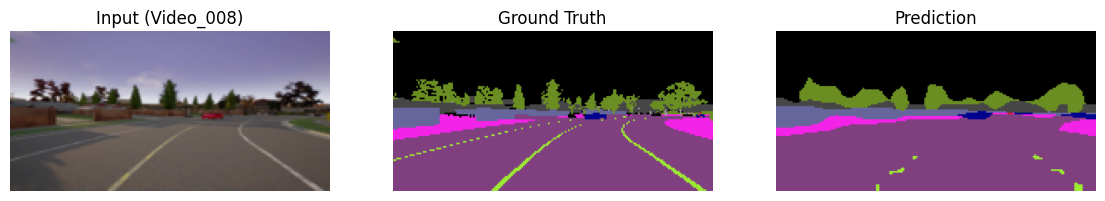

DONE.


In [ ]:
import os, glob, random, re, time
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt

# -------------------------------
# 0) CONFIG
# -------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

ROOT_DIR = r"C:\Users\User\OneDrive\Desktop\pt_scoala\AN3_SEM1\SBC\Proiect\archive 1"
IMAGES_ROOT = os.path.join(ROOT_DIR, "images")
LABELS_ROOT = os.path.join(ROOT_DIR, "labels")
CLASSES_CSV = os.path.join(ROOT_DIR, "classes_rgb_values.csv")
VIDEO_INFO_CSV = os.path.join(ROOT_DIR, "video_info.csv")

assert os.path.isdir(IMAGES_ROOT), f"Missing images/: {IMAGES_ROOT}"
assert os.path.isdir(LABELS_ROOT), f"Missing labels/: {LABELS_ROOT}"
assert os.path.exists(CLASSES_CSV), f"Missing classes_rgb_values.csv: {CLASSES_CSV}"
assert os.path.exists(VIDEO_INFO_CSV), f"Missing video_info.csv: {VIDEO_INFO_CSV}"

device = torch.device("cpu")  
NUM_WORKERS = 0               
PIN_MEMORY = False            

TARGET_H, TARGET_W = 96, 192  
BATCH_SIZE = 1
EPOCHS = 2                    
PRINT_EVERY_PCT = 5           

IGNORE_INDEX = 255
DROP_CLASS_NAME = "Other"     
VAL_MAX_BATCHES = 150         
TEST_MAX_BATCHES = None       

print("Device:", device)
print("Resize:", (TARGET_H, TARGET_W), "| Batch:", BATCH_SIZE, "| Epochs:", EPOCHS)

# -------------------------------
# 1) LOAD classes CSV -> 12 classes RGB LUT
# -------------------------------
classes_df = pd.read_csv(CLASSES_CSV)

def parse_rgb_value_robust(s):
    nums = re.findall(r"\d+", str(s))
    if len(nums) >= 3:
        r,g,b = map(int, nums[:3])
        return (r,g,b)
    if len(nums) == 2:
        r = int(nums[0]); gb = int(nums[1])
        g = gb // 10
        b = gb % 10
        return (r,g,b)
    raise ValueError(f"Can't parse RGB: {s}")

full_class_names = []
full_rgb_list = []
for _, row in classes_df.iterrows():
    full_class_names.append(str(row["semantic_class"]))
    full_rgb_list.append(parse_rgb_value_robust(row["rgb_values"]))

drop_idx = None
for i, name in enumerate(full_class_names):
    if name.strip().lower() == DROP_CLASS_NAME.lower():
        drop_idx = i
        break
if drop_idx is None:
    raise ValueError(f"Cannot find class '{DROP_CLASS_NAME}'. Available: {full_class_names}")

class_names = [n for i,n in enumerate(full_class_names) if i != drop_idx]
rgb_list = [rgb for i,rgb in enumerate(full_rgb_list) if i != drop_idx]
num_classes = len(rgb_list)
assert num_classes == 12, f"Expected 12 classes, got {num_classes}"
print("Using 12 classes (dropped):", full_class_names[drop_idx])
print("Classes:", class_names)

lut = np.full((256*256*256,), IGNORE_INDEX, dtype=np.uint8)
for idx, (r,g,b) in enumerate(rgb_list):
    lut[r*256*256 + g*256 + b] = idx

def mask_rgb_to_class(mask_rgb_np: np.ndarray) -> np.ndarray:
    r = mask_rgb_np[...,0].astype(np.int32)
    g = mask_rgb_np[...,1].astype(np.int32)
    b = mask_rgb_np[...,2].astype(np.int32)
    key = r*256*256 + g*256 + b
    return lut[key]

# -------------------------------
# 2) VIDEO split + pairs
# -------------------------------
def list_video_ids(images_root):
    vids = [d for d in os.listdir(images_root) if os.path.isdir(os.path.join(images_root, d))]
    vids.sort()
    return vids

def build_pairs(video_ids):
    pairs = []
    for vid in video_ids:
        img_dir = os.path.join(IMAGES_ROOT, vid)
        lbl_dir = os.path.join(LABELS_ROOT, vid)
        imgs = sorted(glob.glob(os.path.join(img_dir, "*.png")) +
                      glob.glob(os.path.join(img_dir, "*.jpg")) +
                      glob.glob(os.path.join(img_dir, "*.jpeg")))
        for ip in imgs:
            fn = os.path.basename(ip)
            lp = os.path.join(lbl_dir, fn)
            if os.path.exists(lp):
                pairs.append((ip, lp, vid))
    return pairs

video_ids = list_video_ids(IMAGES_ROOT)
assert len(video_ids) == 28, f"Expected 28 videos (doc), got {len(video_ids)}"

rng = random.Random(SEED)
rng.shuffle(video_ids)
n = len(video_ids)
n_train = int(0.70*n)
n_val   = int(0.15*n)

train_vids = video_ids[:n_train]
val_vids   = video_ids[n_train:n_train+n_val]
test_vids  = video_ids[n_train+n_val:]

train_pairs = build_pairs(train_vids)
val_pairs   = build_pairs(val_vids)
test_pairs  = build_pairs(test_vids)

print("Train videos:", len(train_vids), "pairs:", len(train_pairs))
print("Val videos:", len(val_vids), "pairs:", len(val_pairs))
print("Test videos:", len(test_vids), "pairs:", len(test_pairs))
assert len(train_pairs) > 0, "No train pairs found."

# -------------------------------
# 3) Dataset (no caching) + transforms
# -------------------------------
img_tf = T.Compose([
    T.ToTensor(),
])

class CarlaSegDataset(Dataset):
    def __init__(self, pairs, augment=False):
        self.pairs = pairs
        self.augment = augment

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, i):
        img_path, lbl_path, vid = self.pairs[i]

        img = Image.open(img_path).convert("RGB").resize((TARGET_W, TARGET_H), resample=Image.BILINEAR)
        lbl = Image.open(lbl_path).convert("RGB").resize((TARGET_W, TARGET_H), resample=Image.NEAREST)

        img_np = np.array(img, dtype=np.uint8)
        lbl_np = np.array(lbl, dtype=np.uint8)

        if self.augment and random.random() < 0.5:
            img_np = np.ascontiguousarray(img_np[:, ::-1, :])
            lbl_np = np.ascontiguousarray(lbl_np[:, ::-1, :])

        y = mask_rgb_to_class(lbl_np).astype(np.int64)  
        x = img_tf(Image.fromarray(img_np))             

        return x, torch.from_numpy(y), vid

train_loader = DataLoader(CarlaSegDataset(train_pairs, augment=True),
                          batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(CarlaSegDataset(val_pairs, augment=False),
                          batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader  = DataLoader(CarlaSegDataset(test_pairs, augment=False),
                          batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

print("Batches -> train:", len(train_loader), "val:", len(val_loader), "test:", len(test_loader))

# -------------------------------
# 4) Model (fast) + loss + optim
# -------------------------------
model = torchvision.models.segmentation.fcn_resnet50(weights=None, num_classes=num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# -------------------------------
# 5) Metrics: confusion -> acc, mIoU, IoU/class (low RAM)
# -------------------------------
@torch.no_grad()
def update_confusion(conf, pred, target, num_classes, ignore_index=IGNORE_INDEX):
   
    mask = (target != ignore_index)
    pred = pred[mask]
    target = target[mask]
    if target.numel() == 0:
        return conf
    k = target * num_classes + pred
    bins = torch.bincount(k, minlength=num_classes*num_classes)
    conf += bins.reshape(num_classes, num_classes).cpu()
    return conf

def metrics_from_conf(conf):
    conf = conf.numpy().astype(np.float64)
    acc = np.trace(conf) / (conf.sum() + 1e-9)
    iou = np.zeros((conf.shape[0],), dtype=np.float64)
    for c in range(conf.shape[0]):
        tp = conf[c,c]
        fp = conf[:,c].sum() - tp
        fn = conf[c,:].sum() - tp
        iou[c] = tp / (tp + fp + fn + 1e-9)
    miou = float(np.nanmean(iou))
    return float(acc), miou, iou

@torch.no_grad()
def eval_loader(model, loader, max_batches=None):
    model.eval()
    total_loss = 0.0
    conf = torch.zeros((num_classes, num_classes), dtype=torch.int64)

    nb = 0
    for (x,y,_) in loader:
        x = x.to(device)
        y = y.to(device)

        out = model(x)["out"]
        loss = criterion(out, y)
        total_loss += loss.item()

        pred = out.argmax(1)
        conf = update_confusion(conf, pred, y, num_classes)

        nb += 1
        if max_batches is not None and nb >= max_batches:
            break

    avg_loss = total_loss / max(nb,1)
    acc, miou, iou = metrics_from_conf(conf)
    return avg_loss, acc, miou, iou

# -------------------------------
# 6) TRAIN with % progress + history
# -------------------------------
history = {"epoch": [], "train_loss": [], "val_loss": [], "val_acc": [], "val_miou": []}

def should_print(batch_idx, total_batches):
    step = max(int(total_batches * (PRINT_EVERY_PCT/100.0)), 1)
    return (batch_idx == 1) or (batch_idx == total_batches) or (batch_idx % step == 0)

print("\nSTART TRAINING\n", flush=True)
t0_all = time.time()

for epoch in range(1, EPOCHS+1):
    model.train()
    total_loss = 0.0
    total_batches = len(train_loader)

    t0 = time.time()
    for b, (x,y,_) in enumerate(train_loader, start=1):
        x = x.to(device)
        y = y.to(device)

        out = model(x)["out"]
        loss = criterion(out, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if should_print(b, total_batches):
            pct = 100.0 * b / total_batches
            print(f"Epoch {epoch}/{EPOCHS} | {pct:5.1f}% | batch {b}/{total_batches} | loss {loss.item():.4f}", flush=True)

    train_loss = total_loss / total_batches

    val_loss, val_acc, val_miou, _ = eval_loader(model, val_loader, max_batches=VAL_MAX_BATCHES)

    dt = time.time() - t0
    history["epoch"].append(epoch)
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["val_miou"].append(val_miou)

    print(f"Epoch {epoch} DONE in {dt/60:.1f} min | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_acc={val_acc:.4f} | val_mIoU={val_miou:.4f}\n", flush=True)

t_all = time.time() - t0_all
print(f"TRAINING FINISHED in {t_all/60:.1f} minutes.\n", flush=True)

# -------------------------------
# 7) PLOTS
# -------------------------------
epochs = history["epoch"]

plt.figure(figsize=(10,4))
plt.plot(epochs, history["train_loss"], label="train_loss")
plt.plot(epochs, history["val_loss"], label="val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss curves"); plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(epochs, history["val_acc"], label="val_acc")
plt.xlabel("Epoch"); plt.ylabel("Pixel Accuracy"); plt.title("Validation Accuracy"); plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(epochs, history["val_miou"], label="val_mIoU")
plt.xlabel("Epoch"); plt.ylabel("mIoU"); plt.title("Validation mIoU"); plt.legend()
plt.show()

# -------------------------------
# 8) FINAL TEST (full or limited)
# -------------------------------
test_loss, test_acc, test_miou, test_iou = eval_loader(model, test_loader, max_batches=TEST_MAX_BATCHES)

print("TEST RESULTS")
print("  test_loss:", test_loss)
print("  pixel_acc:", test_acc)
print("  mIoU:", test_miou)
print("\nIoU per class:")
for i, name in enumerate(class_names):
    print(f"  {i:02d} {name:20s} IoU={test_iou[i]:.4f}")

# -------------------------------
# 9) VISUALIZE: Input / GT / Pred (3 examples)
# -------------------------------
@torch.no_grad()
def decode_class_to_rgb(mask_cls: np.ndarray, rgb_list):
    h, w = mask_cls.shape
    out = np.zeros((h,w,3), dtype=np.uint8)
    for idx, (r,g,b) in enumerate(rgb_list):
        out[mask_cls == idx] = (r,g,b)
    return out

@torch.no_grad()
def show_examples(dataset, n=3):
    model.eval()
    for _ in range(n):
        x, y, vid = dataset[random.randint(0, len(dataset)-1)]
        x_in = x.unsqueeze(0).to(device)
        out = model(x_in)["out"]
        pred = out.argmax(1)[0].cpu().numpy()

        img = x.cpu().numpy().transpose(1,2,0)
        img = np.clip(img, 0, 1)

        gt = y.cpu().numpy()
        gt_rgb = decode_class_to_rgb(gt, rgb_list)
        pr_rgb = decode_class_to_rgb(pred, rgb_list)

        plt.figure(figsize=(14,4))
        plt.subplot(1,3,1); plt.imshow(img); plt.title(f"Input ({vid})"); plt.axis("off")
        plt.subplot(1,3,2); plt.imshow(gt_rgb); plt.title("Ground Truth"); plt.axis("off")
        plt.subplot(1,3,3); plt.imshow(pr_rgb); plt.title("Prediction"); plt.axis("off")
        plt.show()

show_examples(CarlaSegDataset(test_pairs, augment=False), n=3)

print("DONE.")


In [ ]:
import cv2
import numpy as np
import os
import random
import glob
from ultralytics import YOLO
import pandas as pd

# ================= CONFIGURARE =================
ROOT_DIR = r"C:\Users\User\OneDrive\Desktop\pt_scoala\AN3_SEM1\SBC\Proiect\archive 1"
IMAGES_ROOT = os.path.join(ROOT_DIR, "images")
VIDEO_INFO_CSV = os.path.join(ROOT_DIR, "video_info.csv")

VIDEO_ID = None            
MODEL_PATH = None          

WINDOW_SIZE = (800, 600)
CONF_TH = 0.25
SHOW_MS = 3000

BRAKE_AREA_RATIO = 0.08
STOP_AREA_RATIO  = 0.15

LEAD_VEHICLE_KEYS = ["car", "vehicle", "truck", "bus", "van"]

BASE_SPEED_KMH = 50

WEATHER_SPEED_FACTOR = {
    "sunny": 1.00,
    "clear": 1.00,
    "cloudy": 0.90,
    "overcast": 0.90,
    "rainy": 0.75,
    "rain": 0.75,
    "wet": 0.80,
    "fog": 0.65,
    "foggy": 0.65,
    "night": 0.85,
}


def find_latest_best_pt(runs_dir="runs"):
    pattern = os.path.join(runs_dir, "detect", "*", "weights", "best.pt")
    candidates = glob.glob(pattern)
    if not candidates:
        return None
    candidates.sort(key=lambda p: os.path.getmtime(p), reverse=True)
    return candidates[0]

def collect_images(images_root, video_id=None, exts=(".jpg", ".jpeg", ".png")):
    img_paths = []
    if video_id is not None:
        folder = os.path.join(images_root, video_id)
        if not os.path.isdir(folder):
            raise FileNotFoundError(f"Nu găsesc folderul video: {folder}")
        for e in exts:
            img_paths += glob.glob(os.path.join(folder, f"*{e}"))
    else:
        vids = [d for d in os.listdir(images_root) if os.path.isdir(os.path.join(images_root, d))]
        vids.sort()
        for vid in vids:
            folder = os.path.join(images_root, vid)
            for e in exts:
                img_paths += glob.glob(os.path.join(folder, f"*{e}"))
    return sorted(img_paths)

def get_video_id_from_path(img_path):
    return os.path.basename(os.path.dirname(img_path))

def load_weather_map(video_info_csv):
    if not os.path.exists(video_info_csv):
        print(" Nu găsesc video_info.csv, vremea va fi 'Unknown'.")
        return {}

    df = pd.read_csv(video_info_csv)
    weather_map = {}
    if "Index" in df.columns and "weather" in df.columns:
        for _, r in df.iterrows():
            idx = int(r["Index"])
            vid = f"Video_{idx:03d}"
            weather_map[vid] = str(r["weather"])
    else:
        print(" CSV nu are coloanele așteptate (Index, weather). Vremea va fi 'Unknown'.")
    return weather_map

def weather_factor(weather_str):
    w = (weather_str or "unknown").strip().lower()
    for key, factor in WEATHER_SPEED_FACTOR.items():
        if key in w:
            return factor
    return 1.0  

def simulator_smart_car():
    print(f"--- ÎNCARC SIMULATORUL ---")
    print("ROOT_DIR:", ROOT_DIR)
    print("IMAGES_ROOT:", IMAGES_ROOT)

    weather_map = load_weather_map(VIDEO_INFO_CSV)

    model_path = MODEL_PATH if MODEL_PATH else find_latest_best_pt("runs")
    if model_path is None or not os.path.exists(model_path):
        print("⚠️  Nu găsesc modelul YOLO antrenat. Folosesc yolov8n.pt (generic).")
        model = YOLO("yolov8n.pt")
    else:
        print(f"✅ Model încărcat: {model_path}")
        model = YOLO(model_path)

    try:
        all_files = collect_images(IMAGES_ROOT, VIDEO_ID)
    except Exception as e:
        print("EROARE la colectare imagini:", e)
        return

    if not all_files:
        print("Eroare: Nu am găsit imagini!")
        return

    print(f"✅ Am găsit {len(all_files)} imagini.")
    print("Apasă 'q' sau 'Esc' pentru stop, 'n' pentru next imediat.")

    while True:
        img_path = random.choice(all_files)
        img = cv2.imread(img_path)
        if img is None:
            continue

        vid = get_video_id_from_path(img_path)
        weather = weather_map.get(vid, "Unknown")
        w_factor = weather_factor(weather)
        suggested_speed = int(round(BASE_SPEED_KMH * w_factor))

        results = model.predict(img, conf=CONF_TH, verbose=False)
        result = results[0]

        display_img = cv2.resize(img, WINDOW_SIZE)
        scale_x = WINDOW_SIZE[0] / img.shape[1]
        scale_y = WINDOW_SIZE[1] / img.shape[0]

        detected_objects = []
        img_h, img_w = img.shape[:2]
        img_area = float(img_w * img_h)
        lead_area_ratio_max = 0.0

        for box in result.boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            conf = float(box.conf[0])
            cls_id = int(box.cls[0])
            class_name = result.names.get(cls_id, str(cls_id))

            detected_objects.append(class_name)

            cn = str(class_name).lower()
            is_lead_vehicle = any(k in cn for k in LEAD_VEHICLE_KEYS)
            if is_lead_vehicle:
                bw = max(0.0, x2 - x1)
                bh = max(0.0, y2 - y1)
                area_ratio = (bw * bh) / (img_area + 1e-9)
                lead_area_ratio_max = max(lead_area_ratio_max, area_ratio)

            sx1, sx2 = int(x1 * scale_x), int(x2 * scale_x)
            sy1, sy2 = int(y1 * scale_y), int(y2 * scale_y)

            box_color = (0, 255, 0)
            if "red" in cn or "stop" in cn:
                box_color = (0, 0, 255)
            elif "speed" in cn:
                box_color = (255, 165, 0)
            elif is_lead_vehicle:
                box_color = (255, 0, 255)

            cv2.rectangle(display_img, (sx1, sy1), (sx2, sy2), box_color, 2)
            cv2.putText(display_img, f"{class_name} {conf:.0%}", (sx1, max(15, sy1 - 10)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, box_color, 2)

        action_text = "CRUISING..."
        action_color = (255, 255, 0)

        if lead_area_ratio_max >= STOP_AREA_RATIO:
            action_text = "STOPPED - VEHICLE AHEAD"
            action_color = (0, 0, 255)
            suggested_speed = 0
        elif lead_area_ratio_max >= BRAKE_AREA_RATIO:
            action_text = "BRAKING - VEHICLE TOO CLOSE"
            action_color = (0, 165, 255)
            suggested_speed = max(5, int(round(suggested_speed * 0.5)))

        # 1) Stop / Red Light
        elif any(name in ["Stop", "Red Light"] for name in detected_objects):
            action_text = "FRANARE DE URGENTA!"
            action_color = (0, 0, 255)
            suggested_speed = 0

        # 2) Limită de viteză
        elif any("Speed Limit" in name for name in detected_objects):
            for name in detected_objects:
                if "Speed Limit" in name:
                    v = name.split()[-1]
                    action_text = f"LIMITARE VITEZA: {v} km/h"
                    action_color = (0, 165, 255)
                    # sugerăm viteza minimă dintre weather și semn
                    try:
                        suggested_speed = min(suggested_speed, int(v))
                    except:
                        pass
                    break

       
        elif "Green Light" in detected_objects:
            action_text = "SEMAFOR VERDE - CONTINUA"
            action_color = (0, 255, 0)

   
        overlay = display_img.copy()
        cv2.rectangle(overlay, (0, WINDOW_SIZE[1]-140), (WINDOW_SIZE[0], WINDOW_SIZE[1]), (0, 0, 0), -1)
        alpha = 0.8
        cv2.addWeighted(overlay, alpha, display_img, 1 - alpha, 0, display_img)

        cv2.putText(display_img, f"ACTIUNE: {action_text}", (20, WINDOW_SIZE[1]-85),
                    cv2.FONT_HERSHEY_DUPLEX, 1.0, action_color, 2)

        det_str = ", ".join(sorted(set(detected_objects))) if detected_objects else "Niciun semn detectat"
        cv2.putText(display_img, f"Senzori: {det_str}", (20, WINDOW_SIZE[1]-20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (200, 200, 200), 1)

        cv2.putText(display_img, f"Vreme: {weather} | Viteza recomandata: {suggested_speed} km/h",
                    (20, WINDOW_SIZE[1]-50), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (220, 220, 220), 2)

        cv2.putText(display_img, f"Lead vehicle area ratio: {lead_area_ratio_max:.3f}",
                    (20, WINDOW_SIZE[1]-115), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (200, 200, 200), 1)

        cv2.putText(display_img, f"{vid} | {os.path.basename(img_path)}", (20, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

        cv2.imshow("Sistem Autonom de Navigatie - Proiect", display_img)

        key = cv2.waitKey(SHOW_MS)
        if key == ord('q') or key == 27:
            break
        elif key == ord('n'):
            continue

    cv2.destroyAllWindows()

if __name__ == "__main__":
    simulator_smart_car()


--- ÎNCARC SIMULATORUL ---
ROOT_DIR: C:\Users\User\OneDrive\Desktop\pt_scoala\AN3_SEM1\SBC\Proiect\archive 1
IMAGES_ROOT: C:\Users\User\OneDrive\Desktop\pt_scoala\AN3_SEM1\SBC\Proiect\archive 1\images
⚠️  Nu găsesc modelul YOLO antrenat. Folosesc yolov8n.pt (generic).
✅ Am găsit 10767 imagini.
Apasă 'q' sau 'Esc' pentru stop, 'n' pentru next imediat.
